In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
input_dim = 784
hidden_dim = 200
latent_dim = 20
epochs = 30
learning_rate = 3e-4
batch_size = 32

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

In [4]:
def reparameterize(mu, sigma):
    eps = torch.rand_like(sigma)
    z = mu + eps * sigma
    return z


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
    
    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)
        
        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])
dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0
    
    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        cnt += 1
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(loss_avg)

40.23861585083008
28.83508255106608
26.88836869608561
25.91540761617025
25.16470361022949
24.57231968688965
24.097492224121094
23.740768357340496
23.424049498494465
23.14253828531901
22.930784661865236
22.7457648050944
22.57638533121745
22.415285564168293
22.289832556152344
22.195650115966796
22.095083028157553
21.98494531351725
21.931210067749024
21.86417852681478
21.81467976277669
21.737972549438478
21.69721653035482
21.62610776163737
21.57785914815267
21.54595155029297
21.487290861002606
21.47052256978353
21.43993700358073
21.386349510701496


In [7]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)
    
grid_img = torchvision.utils.make_grid(
    generated_images,
    nrow=8,
    padding=2,
    normalize=True
)

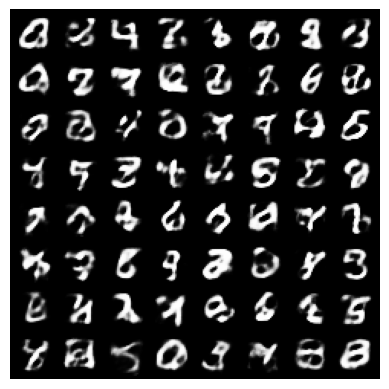

In [8]:
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()